In [3]:
# !pip install torch torchvision google-cloud-storage
# !pip install opencv-python
# !pip install wandb
# !pip install librosa

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.8/20.8 MB 141.4 MB/s eta 0:00:00


In [1]:
import cv2
import gc
import io
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tempfile
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import wandb
from concurrent.futures import ThreadPoolExecutor, as_completed
from sklearn.metrics import (roc_curve, recall_score, precision_score, accuracy_score, roc_auc_score,
                             average_precision_score, confusion_matrix, classification_report, precision_recall_curve)
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader, Subset
from tqdm.notebook import tqdm

In [3]:
# ------------------------------
# 1. CSVAudioLoader 从Meta_csv读取音频
# ------------------------------
class CSVAudioLoader:
    def __init__(self, target_sr=16000, max_workers=96):
        """
        Initialize CSVAudioLoader
        :param target_sr: target sampling rate, default 16000
        :param max_workers: maximum number of threads in multithreading, default 96
        """
        self.target_sr = target_sr
        self.max_workers = max_workers

    def load_audio_from_csv(self, csv_file, allowed_set=None, allowed_data_source="all"):
        """
        Load audio data from a CSV file and filter records based on allowed_set and allowed_data_source.
        The CSV file should contain the following fields:
        - absolute_path: absolute path to the audio file
        - data_source: data source (e.g. "itw")
        - speaker: speaker information
        - label_set: label and dataset combination (e.g. (1, 'train'))
        - Set: dataset partition (e.g. "train", "test", "in-test")
        
        :param csv_file: CSV file path
        :param allowed_set: list of Set values ​​allowed to be loaded (e.g. ["train", "test", "in-test"]), if None, no Set filtering is performed
        :param allowed_data_source: list of data_source values ​​allowed to be loaded, if set to "all", no filtering is performed, otherwise it must be a list, e.g. ["itw"]
        :return: Returns a list with each element as a tuple, (absolute_path, audio, sr, speaker, label)
         """

        df = pd.read_csv(csv_file)
        # 根据 allowed_set 过滤数据（假设 CSV 中的列名为 "Set"）
        if allowed_set is not None:
            df = df[df["Set"].isin(allowed_set)]
        # 根据 allowed_data_source 过滤数据（当其不等于 "all" 时）
        if allowed_data_source != "all":
            df = df[df["data_source"].isin(allowed_data_source)]

        def load_audio(row):
            file_path = row["absolute_path"]
            try:
                audio, sr = librosa.load(file_path, sr=self.target_sr, mono=True)
                return (file_path, audio, sr, row["speaker"], row['label'])
            except Exception as e:
                print(f"Error loading audio from {file_path}: {e}")
                return None

        records = []
        with ThreadPoolExecutor(max_workers=self.max_workers) as executor:
            futures = {executor.submit(load_audio, row): idx for idx, row in df.iterrows()}
            for future in tqdm(as_completed(futures), total=len(futures), desc="Loading audio from CSV"):
                result = future.result()
                if result is not None:
                    records.append(result)
        return records

In [4]:
audio_loader = CSVAudioLoader(target_sr=16000, max_workers=96)
train_audio = audio_loader.load_audio_from_csv(csv_file="../Data/meta_final.csv", allowed_set=["train"],
                                               allowed_data_source=["itw"])

Loading audio from CSV:   0%|          | 0/15205 [00:00<?, ?it/s]

In [5]:
# ------------------------------
# 3. 定义 MFCCExtractor 
# ------------------------------
class MFCCExtractor:
    def __init__(self, n_mfcc=60, hop_length=512, n_fft=1024, target_frames=400, max_workers=80, **kwargs):
        """
        初始化 MFCC 提取器，可自定义 MFCC 参数，并将输出统一调整为 (n_mfcc, target_frames)
        :param n_mfcc: MFCC 数量，默认 60
        :param hop_length: 帧移，默认 512
        :param n_fft: FFT 点数，默认 1024
        :param target_frames: 目标时间帧数，默认 400（仅用于 extract_features 中的 resize）
        :param max_workers: 多线程时的线程数，默认 80
        :param kwargs: 其他参数传给 librosa.feature.mfcc
        """
        self.n_mfcc = n_mfcc
        self.hop_length = hop_length
        self.n_fft = n_fft
        self.target_frames = target_frames
        self.max_workers = max_workers
        self.kwargs = kwargs

    def extract_features(self, audio, sr):
        """
        对单个音频信号提取 MFCC 特征，并通过 cv2.resize 调整输出为固定尺寸 (n_mfcc, target_frames)
        :param audio: 音频信号 (numpy 数组)
        :param sr: 采样率
        :return: MFCC 特征矩阵 (numpy 数组)，shape 为 (n_mfcc, target_frames)
        """
        mfccs = librosa.feature.mfcc(
            y=audio,
            sr=sr,
            n_mfcc=self.n_mfcc,
            hop_length=self.hop_length,
            n_fft=self.n_fft,
            **self.kwargs
        )
        resized_mfcc = cv2.resize(mfccs.astype(np.float32), (self.target_frames, self.n_mfcc),
                                  interpolation=cv2.INTER_LINEAR)
        return resized_mfcc

    def extract_batch(self, audio_data):
        """
        对一批音频数据进行批量 MFCC 特征提取，使用多线程方式。
        每个音频数据应为至少包含以下字段的元组：
          (file_path, audio, sr, data_source, speaker, Set, label)
        提取后返回 (mfcc_features, speaker, label) 供后续防止 speaker 泄露和标签保存使用。
        :param audio_data: 列表，每个元素至少包含 (file_path, audio, sr, speaker, label)
        :return: 列表，每个元素为 (mfcc_features, speaker, label)
        """

        def process_row(row):
            # row 中的顺序: 0: file_path, 1: audio, 2: sr, 3: speaker 4: label
            audio = row[1]
            sr = row[2]
            mfcc_features = self.extract_features(audio, sr)
            speaker = row[3]
            label = row[4]
            return (mfcc_features, speaker, label)

        features = []
        with ThreadPoolExecutor(max_workers=self.max_workers) as executor:
            futures = {executor.submit(process_row, row): row for row in audio_data}
            for future in tqdm(as_completed(futures), total=len(futures), desc="Extracting MFCC features"):
                try:
                    result = future.result()
                    features.append(result)
                except Exception as e:
                    print(f"Error extracting features: {e}")
        return features


In [7]:
gc.collect()

0

In [9]:
# 初始化 MFCCExtractor，并设置所需的参数，例如 n_mfcc, hop_length, n_fft 等
mfcc_extractor = MFCCExtractor(n_mfcc=60, hop_length=256, n_fft=1024, max_workers=96)
mfcc_features = mfcc_extractor.extract_batch(train_audio)

Extracting MFCC features:   0%|          | 0/15205 [00:00<?, ?it/s]

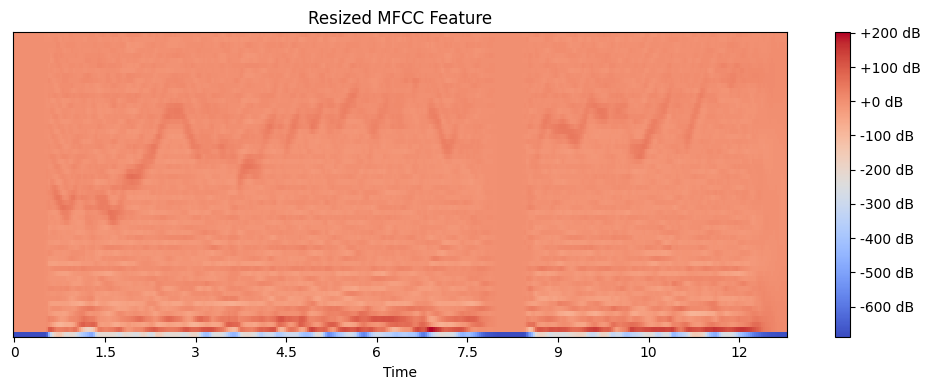

In [10]:
def visualize_feature(feature, sr=16000, hop_length=512, title="MFCC Feature"):
    """
    可视化单个 MFCC 特征矩阵

    :param feature: MFCC 特征矩阵，形状为 (n_mfcc, target_frames) 例如 (60, 400)
    :param sr: 采样率（用于时间轴标注）
    :param hop_length: 帧移（用于时间轴标注）
    :param title: 图像标题
    """
    plt.figure(figsize=(10, 4))
    # 使用 librosa.display.specshow 显示，x_axis='time' 会根据 sr 和 hop_length 自动计算时间轴
    librosa.display.specshow(feature, x_axis='time', sr=sr, hop_length=hop_length)
    plt.colorbar(format='%+2.0f dB')
    plt.title(title)
    plt.tight_layout()
    plt.show()


# ------------------------------
demo_feature, speaker, label = mfcc_features[0]
visualize_feature(demo_feature, sr=16000, hop_length=512, title="Resized MFCC Feature")


In [11]:
# ------------------------------
# 4. 定义 Dataset 类 & GroupKFold
# ------------------------------
class AudioMFCCDataset(Dataset):
    """
    AudioMFCCDataset 用于加载 MFCC 特征及对应标签和 speaker 信息。

    输入数据格式：
      - samples: 列表，每个元素为 (mfcc_features, speaker, label)
        其中 mfcc_features 为提取好的 MFCC 特征（形状为 (n_mfcc, target_frames)），
        speaker 为说话人标识，
        label 为音频对应的标签（例如 1 表示真实，0 表示伪造）
      
    可选参数 transform 可用于对特征进行预处理或数据增强。
    """

    def __init__(self, samples, transform=None):
        """
        初始化 AudioMFCCDataset

        :param samples: list，每个元素为 (mfcc_features, speaker, label)
        :param transform: 可选，传入一个函数或 transform 对象，对特征进行预处理
        """
        self.samples = samples
        self.transform = transform

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, index):
        """
        获取指定索引处的样本数据

        :param index: int，样本索引
        :return: tuple (features, label, speaker)
                 features: torch.Tensor 类型，形状为 (1, n_mfcc, target_frames)
                 label: torch.Tensor 类型的标签（0 或 1）
                 speaker: 原始的 speaker 信息（字符串）
        """
        if index < 0 or index >= len(self.samples):
            raise IndexError("Index {} out of range".format(index))

        mfcc_features, speaker, label = self.samples[index]

        # 如果定义了数据变换，则应用该变换
        if self.transform:
            mfcc_features = self.transform(mfcc_features)

        # 转换为 tensor
        features = torch.tensor(mfcc_features, dtype=torch.float32)

        # 确保 features 为 3D: (channels, n_mfcc, target_frames)
        if features.dim() == 2:
            features = features.unsqueeze(0)
        elif features.dim() == 3 and features.shape[0] != 1:
            features = features[0:1, ...]

        label = torch.tensor(label, dtype=torch.long)
        return features, label, speaker

    def get_group_splits(self, n_splits=5, random_state=None):
        """
        使用 GroupKFold 根据 speaker 信息划分训练和验证集合，防止同一 speaker 出现在不同 Fold 中。
        
        :param n_splits: 拆分的 Fold 数量，默认 5
        :param random_state: 随机种子，GroupKFold 本身不支持随机种子，如果需要随机打乱，请先自行打乱数据。
        :return: 返回一个列表，每个元素为 (train_idx, valid_idx)
        """
        n_samples = len(self)
        indices = np.arange(n_samples)
        # 每个样本的 speaker 信息存放在 self.samples 中，格式为 (mfcc_features, speaker, label)
        groups = [self.samples[i][1] for i in range(n_samples)]
        gkf = GroupKFold(n_splits=n_splits)
        splits = list(gkf.split(indices, groups=groups))
        return splits



In [18]:
# ----------------------------------------
# 5. Define a simple CNN&LSTM Model
# ----------------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"--device_available: {device}--")


class CNNBiLSTMClassifier(nn.Module):
    def __init__(self, lstm_hidden_size=128, lstm_num_layers=1):
        """
        构造函数：
          lstm_hidden_size: BiLSTM 隐藏层单元数
          lstm_num_layers: BiLSTM 层数
        """
        super(CNNBiLSTMClassifier, self).__init__()

        # CNN 部分
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        # 此处采用池化核大小 (2,1) 主要降低高度维度
        self.pool1 = nn.MaxPool2d(kernel_size=(2, 1))
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=(2, 1))

        # 使用自适应平均池化将高度降到1，保留宽度（时间步数）
        self.adaptive_pool = nn.AdaptiveAvgPool2d((1, None))
        self.dropout = nn.Dropout(0.5)

        # BiLSTM 部分
        # 输入特征数为 64（CNN 输出通道数）
        self.bilstm = nn.LSTM(input_size=64,
                              hidden_size=lstm_hidden_size,
                              num_layers=lstm_num_layers,
                              bidirectional=True,
                              batch_first=False)  # LSTM 要求输入形状为 (seq_len, batch, feature)

        # 全连接层，将 BiLSTM 双向（即 hidden_size * 2）的隐藏状态映射到1个输出
        self.fc = nn.Linear(lstm_hidden_size * 2, 1)

    def forward(self, x):
        """
        输入 x: (batch, 1, 60, 400)
        """
        # CNN 部分：提取局部特征
        x = torch.relu(self.conv1(x))  # -> (batch, 32, 60, 400)
        x = self.pool1(x)  # -> (batch, 32, 30, 400)
        x = torch.relu(self.conv2(x))  # -> (batch, 64, 30, 400)
        x = self.pool2(x)  # -> (batch, 64, 15, 400)

        # 自适应平均池化将高度降为 1，保留宽度（即时间步数），得到 (batch, 64, 1, 400)
        x = self.adaptive_pool(x)
        x = x.squeeze(2)  # -> (batch, 64, 400)

        # LSTM 要求输入形状为 (seq_len, batch, feature)，此处将宽度作为时间步长
        x = x.permute(2, 0, 1)  # -> (400, batch, 64)

        # BiLSTM 层：输出全部时间步的特征以及最后的隐藏状态
        lstm_out, (h_n, c_n) = self.bilstm(x)

        # h_n shape: (num_layers * num_directions, batch, hidden_size)
        # 这里采用单层双向 LSTM 的情况，即 h_n 的形状为 (2, batch, lstm_hidden_size)
        # 拼接正反向最后一层的隐藏状态作为整体特征向量
        if self.bilstm.bidirectional:
            # 注意：对于多层的情况，可选择只取最后一层
            h_forward = h_n[0]  # (batch, lstm_hidden_size)
            h_backward = h_n[1]  # (batch, lstm_hidden_size)
            h = torch.cat((h_forward, h_backward), dim=1)  # -> (batch, lstm_hidden_size*2)
        else:
            h = h_n[-1]  # (batch, lstm_hidden_size)

        h = self.dropout(h)
        out = self.fc(h)  # (batch, 1)
        out = torch.sigmoid(out)

        return out







--device_available: cuda--


In [19]:
model = CNNBiLSTMClassifier(lstm_hidden_size=128, lstm_num_layers=1).to(device)
print(model)

dummy_input = torch.randn(2, 1, 60, 400).to(device)
output = model(dummy_input)
print("model output:", output)

CNNBiLSTMClassifier(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=(2, 1), stride=(2, 1), padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=(2, 1), stride=(2, 1), padding=0, dilation=1, ceil_mode=False)
  (adaptive_pool): AdaptiveAvgPool2d(output_size=(1, None))
  (dropout): Dropout(p=0.5, inplace=False)
  (bilstm): LSTM(64, 128, bidirectional=True)
  (fc): Linear(in_features=256, out_features=1, bias=True)
)
模型输出: tensor([[0.4660],
        [0.4506]], device='cuda:0', grad_fn=<SigmoidBackward0>)


In [20]:
# ----------------------------------------
# 5. Define CNNLSTMTrainer
# ----------------------------------------
class CNNTrainer:
    """
    Trainer 类整合了模型定义、训练过程、早停、checkpoint 保存以及 wandb 可视化。
    使用 CNNClassifier 模型进行训练。
    """

    def __init__(self, train_dataloader, val_dataloader=None, device=None, lr=0.001, patience=4,
                 checkpoint_path="CNNBiLSTM.pt", project_name="DeepFake4Celeb_CNNBiLSTM"):
        self.train_dataloader = train_dataloader
        self.val_dataloader = val_dataloader
        self.device = device if device else torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.checkpoint_path = checkpoint_path
        self.patience = patience

        # 使用 CNNBiLSTMClassifier 模型
        self.model = CNNBiLSTMClassifier().to(self.device)

        # 定义损失函数和优化器
        self.criterion = nn.BCELoss()
        self.optimizer = optim.Adam(self.model.parameters(), lr=lr)

        # 初始化 wandb
        wandb.init(project=project_name)
        wandb.watch(self.model, log="all")

        # 用于保存最佳模型指标（以验证 loss 为标准）
        self.best_val_loss = float('inf')
        self.no_improve_count = 0

    def train_one_epoch(self):
        self.model.train()
        running_loss = 0.0
        running_correct = 0
        total_samples = 0

        progress_bar = tqdm(self.train_dataloader, desc="Training", leave=False)
        # 假设 DataLoader 返回 (features, labels, speaker)，这里忽略 speaker
        for features, labels, _ in progress_bar:
            features = features.to(self.device)
            labels = labels.to(self.device).float()

            self.optimizer.zero_grad()
            outputs = self.model(features).squeeze(1)
            loss = self.criterion(outputs, labels)
            loss.backward()
            self.optimizer.step()

            running_loss += loss.item() * labels.size(0)
            preds = (outputs >= 0.5).long()
            running_correct += (preds == labels.long()).sum().item()
            total_samples += labels.size(0)

            progress_bar.set_postfix(loss=loss.item())

        epoch_loss = running_loss / total_samples
        epoch_acc = running_correct / total_samples
        return epoch_loss, epoch_acc

    def validate_one_epoch(self):
        if self.val_dataloader is None:
            return None, None

        self.model.eval()
        running_loss = 0.0
        running_correct = 0
        total_samples = 0

        progress_bar = tqdm(self.val_dataloader, desc="Validating", leave=False)
        with torch.no_grad():
            for features, labels, _ in progress_bar:
                features = features.to(self.device)
                labels = labels.to(self.device).float()

                outputs = self.model(features).squeeze(1)
                loss = self.criterion(outputs, labels)
                running_loss += loss.item() * labels.size(0)

                preds = (outputs >= 0.5).long()
                running_correct += (preds == labels.long()).sum().item()
                total_samples += labels.size(0)

                progress_bar.set_postfix(loss=loss.item())

        val_loss = running_loss / total_samples
        val_acc = running_correct / total_samples
        return val_loss, val_acc

    def save_model(self, filepath):
        """保存当前模型参数到指定文件"""
        torch.save(self.model.state_dict(), filepath)
        print(f"Model saved to {filepath}")

    def load_model(self, filepath):
        """加载模型参数"""
        self.model.load_state_dict(torch.load(filepath, map_location=self.device))
        self.model.to(self.device)
        print(f"Model loaded from {filepath}")

    def predict(self, test_dataloader):
        """
        对测试数据进行预测，返回预测结果列表
        """
        self.model.eval()
        predictions = []
        with torch.no_grad():
            for features, _, _ in test_dataloader:
                features = features.to(self.device)
                outputs = self.model(features).squeeze(1)
                preds = (outputs >= 0.5).long().cpu().numpy()
                predictions.extend(preds)
        return predictions

    def fit(self, num_epochs=20):
        for epoch in range(num_epochs):
            train_loss, train_acc = self.train_one_epoch()
            val_loss, val_acc = self.validate_one_epoch()

            if val_loss is not None:
                print(
                    f"Epoch [{epoch + 1}/{num_epochs}] | Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
            else:
                print(f"Epoch [{epoch + 1}/{num_epochs}] | Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")

            # 若验证 loss 改进，则保存最佳模型，并重置未改进计数器；否则累计未改进轮数
            if val_loss is not None:
                if val_loss < self.best_val_loss:
                    self.best_val_loss = val_loss
                    self.no_improve_count = 0
                    self.save_model(self.checkpoint_path)
                else:
                    self.no_improve_count += 1
                    print(f"No improvement count: {self.no_improve_count}/{self.patience}")
                    if self.no_improve_count >= self.patience:
                        print("Early stopping triggered.")
                        break

            log_dict = {
                "train_loss": train_loss,
                "train_acc": train_acc,
                "epoch": epoch + 1
            }
            if val_loss is not None:
                log_dict["val_loss"] = val_loss
                log_dict["val_acc"] = val_acc

            wandb.log(log_dict)

In [14]:
# ------------------------------
# 构造数据集和 DataLoader
# ------------------------------
dataset = AudioMFCCDataset(mfcc_features)

# 使用 GroupKFold 划分，防止同一 speaker 出现在训练和验证集中
splits = dataset.get_group_splits(n_splits=6)
train_idx, valid_idx = splits[0]  # 取第一个拆分
print(f"Train samples: {len(train_idx)}, Validation samples: {len(valid_idx)}")

from torch.utils.data import Subset

train_dataset = Subset(dataset, train_idx)
valid_dataset = Subset(dataset, valid_idx)

# 构造 DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=16)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False, num_workers=16)

Train samples: 11755, Validation samples: 3450


In [21]:
trainer = CNNTrainer(
    train_dataloader=train_loader,
    val_dataloader=valid_loader,
    device=device,
    lr=0.0001,
    patience=5,
    checkpoint_path="CNNBiLSTM.pt",
    project_name="DeepFake4Celeb_CNNBiLSTM"
)

trainer.fit(num_epochs=50)

Training:   0%|          | 0/368 [00:00<?, ?it/s]

Validating:   0%|          | 0/108 [00:00<?, ?it/s]

Epoch [1/50] | Train Loss: 0.3001, Train Acc: 0.8809 | Val Loss: 0.2017, Val Acc: 0.9090
Model saved to deepfake_detection_best.pt


Training:   0%|          | 0/368 [00:00<?, ?it/s]

Validating:   0%|          | 0/108 [00:00<?, ?it/s]

Epoch [2/50] | Train Loss: 0.1057, Train Acc: 0.9660 | Val Loss: 0.0842, Val Acc: 0.9629
Model saved to deepfake_detection_best.pt


Training:   0%|          | 0/368 [00:00<?, ?it/s]

Validating:   0%|          | 0/108 [00:00<?, ?it/s]

Epoch [3/50] | Train Loss: 0.0773, Train Acc: 0.9768 | Val Loss: 0.1009, Val Acc: 0.9548
No improvement count: 1/5


Training:   0%|          | 0/368 [00:00<?, ?it/s]

Validating:   0%|          | 0/108 [00:00<?, ?it/s]

Epoch [4/50] | Train Loss: 0.0703, Train Acc: 0.9784 | Val Loss: 0.1050, Val Acc: 0.9496
No improvement count: 2/5


Training:   0%|          | 0/368 [00:00<?, ?it/s]

Validating:   0%|          | 0/108 [00:00<?, ?it/s]

Epoch [5/50] | Train Loss: 0.0628, Train Acc: 0.9819 | Val Loss: 0.1229, Val Acc: 0.9487
No improvement count: 3/5


Training:   0%|          | 0/368 [00:00<?, ?it/s]

Validating:   0%|          | 0/108 [00:00<?, ?it/s]

Epoch [6/50] | Train Loss: 0.0593, Train Acc: 0.9820 | Val Loss: 0.0654, Val Acc: 0.9754
Model saved to deepfake_detection_best.pt


Training:   0%|          | 0/368 [00:00<?, ?it/s]

Validating:   0%|          | 0/108 [00:00<?, ?it/s]

Epoch [7/50] | Train Loss: 0.0571, Train Acc: 0.9824 | Val Loss: 0.1154, Val Acc: 0.9513
No improvement count: 1/5


Training:   0%|          | 0/368 [00:00<?, ?it/s]

Validating:   0%|          | 0/108 [00:00<?, ?it/s]

Epoch [8/50] | Train Loss: 0.0512, Train Acc: 0.9841 | Val Loss: 0.1619, Val Acc: 0.9296
No improvement count: 2/5


Training:   0%|          | 0/368 [00:00<?, ?it/s]

Validating:   0%|          | 0/108 [00:00<?, ?it/s]

Epoch [9/50] | Train Loss: 0.0441, Train Acc: 0.9855 | Val Loss: 0.0417, Val Acc: 0.9800
Model saved to deepfake_detection_best.pt


Training:   0%|          | 0/368 [00:00<?, ?it/s]

Validating:   0%|          | 0/108 [00:00<?, ?it/s]

Epoch [10/50] | Train Loss: 0.0436, Train Acc: 0.9869 | Val Loss: 0.0694, Val Acc: 0.9655
No improvement count: 1/5


Training:   0%|          | 0/368 [00:00<?, ?it/s]

Validating:   0%|          | 0/108 [00:00<?, ?it/s]

Epoch [11/50] | Train Loss: 0.0357, Train Acc: 0.9877 | Val Loss: 0.1065, Val Acc: 0.9603
No improvement count: 2/5


Training:   0%|          | 0/368 [00:00<?, ?it/s]

Validating:   0%|          | 0/108 [00:00<?, ?it/s]

Epoch [12/50] | Train Loss: 0.0416, Train Acc: 0.9853 | Val Loss: 0.0668, Val Acc: 0.9693
No improvement count: 3/5


Training:   0%|          | 0/368 [00:00<?, ?it/s]

Validating:   0%|          | 0/108 [00:00<?, ?it/s]

Epoch [13/50] | Train Loss: 0.0327, Train Acc: 0.9891 | Val Loss: 0.1269, Val Acc: 0.9467
No improvement count: 4/5


Training:   0%|          | 0/368 [00:00<?, ?it/s]

Validating:   0%|          | 0/108 [00:00<?, ?it/s]

Epoch [14/50] | Train Loss: 0.0333, Train Acc: 0.9884 | Val Loss: 0.0860, Val Acc: 0.9614
No improvement count: 5/5
Early stopping triggered.


# Evaluation on Test

In [79]:
test_audio = audio_loader.load_audio_from_csv(csv_file="../Data/meta_fianl.csv", allowed_set=["test"],
                                              allowed_data_source="all")
mfcc4test = mfcc_extractor.extract_batch(test_audio)
mfcc4test_dataset = AudioMFCCDataset(mfcc4test)
test_dataloader = DataLoader(mfcc4test_dataset, batch_size=32, shuffle=False)
trainer.load_model("CNNBiLSTM.pt")

Model loaded from deepfake_detection_best.pt


In [80]:
# 打印 test_dataloader 的类型和长度（batch 数量）
print("Test DataLoader type:", type(test_dataloader))
print("Number of batches:", len(test_dataloader))

# 遍历前几个 batch 并打印信息
for i, batch in enumerate(test_dataloader):
    print(f"\nBatch {i}:")
    # 假设每个 batch 返回 (features, labels, speaker)
    if isinstance(batch, (list, tuple)) and len(batch) >= 2:
        features = batch[0]
        labels = batch[1]
        print(" - Features shape:", features.shape)
        print(" - Labels shape:", labels.shape)
        # speaker 信息可能是列表或 tensor，这里只打印第一个 sample 的 speaker 信息
        if len(batch) >= 3:
            speakers = batch[2]
            print(" - Speakers sample:", speakers[0])
    else:
        print(" - Batch content:", batch)

    # 仅打印前 2 个 batch 的信息
    if i >= 1:
        break

Test DataLoader type: <class 'torch.utils.data.dataloader.DataLoader'>
Number of batches: 1893

Batch 0:
 - Features shape: torch.Size([32, 1, 60, 400])
 - Labels shape: torch.Size([32])
 - Speakers sample: ljspeech_waveglow

Batch 1:
 - Features shape: torch.Size([32, 1, 60, 400])
 - Labels shape: torch.Size([32])
 - Speakers sample: Eddie_Izzard


In [90]:
def evaluate_model(trainer, test_dataloader):
    """
    对测试集进行评估，计算 recall, precision, accuracy, AUC, PR AUC, EER, 混淆矩阵等指标，
    并绘制 Precision-Recall 曲线和 ROC 曲线。

    参数：
    ------
    trainer : CNNTrainer 实例
        包含训练好模型和设备信息
    test_dataloader : DataLoader
        测试数据的 DataLoader，建议返回格式为 (features, speaker, labels)
    返回：
    ------
    metrics : dict
        包含各项评估指标的字典，方便 wandb.log() 记录
    """
    from sklearn.metrics import (roc_curve, precision_recall_curve, roc_auc_score,
                                 average_precision_score, confusion_matrix,
                                 classification_report, accuracy_score, recall_score, precision_score)
    import numpy as np
    import matplotlib.pyplot as plt

    trainer.model.eval()
    all_preds = []
    all_probs = []
    all_labels = []

    with torch.no_grad():
        for batch in tqdm(test_dataloader, desc="Evaluating", leave=False):
            # 如果返回的是 (features, speaker, labels) 则解包为 features, speaker, labels
            if len(batch) == 3:
                features, labels, _ = batch
            else:
                features, labels = batch

            # 如果 labels 不是 Tensor，则尝试转换为 Tensor
            if not isinstance(labels, torch.Tensor):
                try:
                    # 如果 labels 是列表或 tuple，且元素为字符串，则先转换为 float
                    if isinstance(labels, (list, tuple)) and isinstance(labels[0], str):
                        labels = torch.tensor([float(l) for l in labels], dtype=torch.float32)
                    else:
                        labels = torch.tensor(labels, dtype=torch.float32)
                except Exception as e:
                    print("Error converting labels to tensor:", e)
                    continue

            features = features.to(trainer.device)
            labels = labels.to(trainer.device).float()

            outputs = trainer.model(features).squeeze(1)  # 输出形状 (batch,)
            probs = outputs.cpu().numpy()  # 概率值
            preds = (outputs >= 0.5).long().cpu().numpy()  # 二分类预测

            all_preds.extend(preds)
            all_probs.extend(probs)
            all_labels.extend(labels.cpu().numpy())

    all_preds = np.array(all_preds)
    all_probs = np.array(all_probs)
    all_labels = np.array(all_labels)

    recall_val = recall_score(all_labels, all_preds)
    precision_val = precision_score(all_labels, all_preds)
    accuracy_val = accuracy_score(all_labels, all_preds)
    auc_score = roc_auc_score(all_labels, all_probs)
    average_precision = average_precision_score(all_labels, all_probs)
    conf_matrix = confusion_matrix(all_labels, all_preds)
    report = classification_report(all_labels, all_preds)

    # 计算 Precision-Recall 曲线数据
    precision_curve, recall_curve, _ = precision_recall_curve(all_labels, all_probs)

    # 计算 ROC 曲线数据
    fpr, tpr, thresholds = roc_curve(all_labels, all_probs)
    fnr = 1 - tpr
    abs_diffs = np.abs(fpr - fnr)
    idx_eer = np.nanargmin(abs_diffs)
    eer = fpr[idx_eer]

    print("Accuracy: {:.4f}".format(accuracy_val))
    print("Precision: {:.4f}".format(precision_val))
    print("Recall: {:.4f}".format(recall_val))
    print("AUC: {:.4f}".format(auc_score))
    print("Average Precision (PR AUC): {:.4f}".format(average_precision))
    print("EER: {:.4f}".format(eer))
    print("Confusion Matrix:\n", conf_matrix)
    print("Classification Report:\n", report)

    # 绘制 Precision-Recall 曲线
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(recall_curve, precision_curve, marker='.', label="PR Curve")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve")
    plt.legend()
    plt.grid(True)

    # 绘制 ROC 曲线
    plt.subplot(1, 2, 2)
    plt.plot(fpr, tpr, marker='.', label="ROC Curve (AUC = {:.4f})".format(auc_score))
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label="Random")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    metrics = {
        "accuracy": accuracy_val,
        "precision": precision_val,
        "recall": recall_val,
        "auc": auc_score,
        "average_precision": average_precision,
        "eer": eer,
        "confusion_matrix": conf_matrix.tolist(),
        "classification_report": report
    }
    return metrics

Evaluating:   0%|          | 0/1893 [00:00<?, ?it/s]

Accuracy: 0.5531
Precision: 0.5585
Recall: 0.9336
AUC: 0.5905
Average Precision (PR AUC): 0.6776
EER: 0.4435
Confusion Matrix:
 [[ 2084 24836]
 [ 2236 31415]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.48      0.08      0.13     26920
         1.0       0.56      0.93      0.70     33651

    accuracy                           0.55     60571
   macro avg       0.52      0.51      0.42     60571
weighted avg       0.52      0.55      0.45     60571



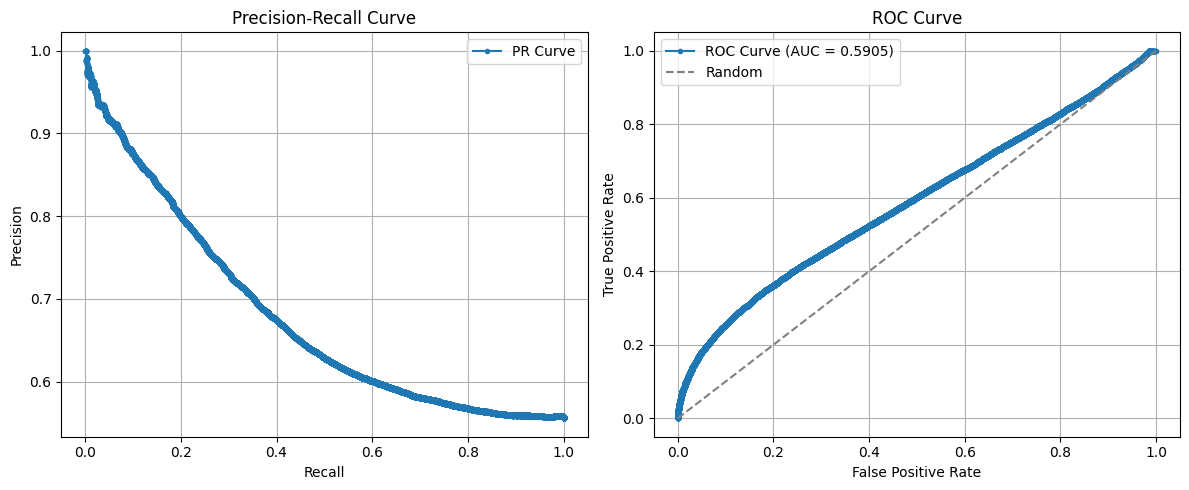

In [91]:
# 使用示例：
# 假设 test_dataloader 已构造好，并且 trainer 是训练好的 CNNTrainer 对象
metrics = evaluate_model(trainer, test_dataloader)

# 记录指标到 wandb
wandb.log(metrics)

In [87]:
metrics

{'accuracy': 0.5530534414158591,
 'precision': 0.5584789603740378,
 'recall': 0.9335532376452409,
 'auc': 0.5904901441565006,
 'average_precision': 0.6775763370530046,
 'eer': 0.44346210995542346,
 'confusion_matrix': [[2084, 24836], [2236, 31415]],
 'classification_report': '              precision    recall  f1-score   support\n\n         0.0       0.48      0.08      0.13     26920\n         1.0       0.56      0.93      0.70     33651\n\n    accuracy                           0.55     60571\n   macro avg       0.52      0.51      0.42     60571\nweighted avg       0.52      0.55      0.45     60571\n'}